# Active Learning via Membership Query Synthesis for Binary Classification 
> Membership Query Synthesis coupled with Instance Pooling for faster convergence via active learning.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]




# Background

This is an implementation of

*Active Learning via Query Synthesis and Nearest Neighbour Search*, by Liantao Wang, Xuelei Hu, Bo Yuan, Jianfeng Lu

http://dx.doi.org/10.1016/j.neucom.2014.06.042

As you'll see, this fits the ModAL API fairly well.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)

# X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)

0.8670833333333333

In [2]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm, trange
import numpy as np

from sklearn.linear_model import LogisticRegression


In [3]:
def initialize_opposite_pair(X_labeled:np.ndarray,y_labeled:np.ndarray,verbose=False):
    '''
    Initialize an opposite pair about the decision boundary based on binary class membership and nearest centroids.
    '''
    clf = NearestCentroid() #to get initial centroids for opposite pairing.
    clf.fit(X_labeled, y_labeled)
    opposite_pair = dict(zip(clf.classes_,clf.centroids_))
    if verbose:
        print(f'Initial opposite pair found as:\n{opposite_pair}')
    return opposite_pair


In [4]:
def get_perp_query(opposite_pair, magnitude:float = 1.0) -> np.ndarray :
    '''
    Synthesize the midperpendicular query given the opposite pair.
    
    Per the paper:
        "This new synthesis can be obtained by adding an orthogonal vector to the mid-point.
         We can find the vector by orthogonalizing a random vector using Gram-Schmit
         process and normalize its magnitude to λ."
    '''
    x_pos,x_neg = tuple(opposite_pair.values())
    x_naught = x_pos - x_neg
    x_r = np.random.rand(*x_naught.shape)
    # Use Gram-Schmit process to make x_r orthogonal to x_o
    x_r = x_r - np.dot(x_r,x_naught) / np.dot(x_naught,x_naught)*x_naught
    # set magnitude
    x_r = magnitude/np.linalg.norm(x_r)*x_r
    x_s = x_r + (x_pos+x_neg)/2
    return x_s


In [5]:
def query_instance(x_s,X_labeled,y_labeled,X_unlabeled,y_unlabeled=None):
    '''
    Query the oracle, or draw from the "unlabeled" label pool.
    '''

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_unlabeled) #want to find nearest neighbor of x_s within unlabeled pool
    _, idx = nn.kneighbors(x_s.reshape(1,-1))
    idx=idx.squeeze()

    x_q = X_unlabeled[idx]
    #query x_q for y_q
    if not isinstance(y_unlabeled, np.ndarray):
        y_q = ask_oracle(x_q,possible_labels=np.unique(y_labeled),label_type='int')
    else:
        y_q=y_unlabeled[idx]
        y_unlabeled = np.delete(y_unlabeled,idx,0) #delete off the used value if matrix is present

    X_labeled = np.vstack((X_labeled,x_q))

    try:
        y_labeled = np.vstack((y_labeled,y_q))
    except: #if label shape cannot be efficiently stacked.
        y_labeled = np.append(y_labeled.flatten(),y_q)

    X_unlabeled= np.delete(X_unlabeled,idx,0)

    data = (X_labeled,y_labeled,X_unlabeled,y_unlabeled)

    return x_q,y_q,data

In [6]:
def find_first_pair(X_labeled:np.ndarray,y_labeled:np.ndarray,X_unlabeled:np.ndarray,y_unlabeled=None,b:int = 64, opposite_pair=None):
    '''
    Find a new opposite pair with 𝑏 bits of precision (unless not enough instances remain) via binary search      about the hyperplane.
    If opposite_pair is not provided, initialize it with centroids of labeled set.
    '''

    if opposite_pair==None:
        opposite_pair=initialize_opposite_pair(X_labeled,y_labeled,verbose=False)
        # "positive" and "negative" in the paper just refers to first and second label

    data=(X_labeled,y_labeled,X_unlabeled,y_unlabeled)
    while b and X_unlabeled.shape[0]>0:

        #synthesize a new instance
        x_pos,x_neg=tuple(opposite_pair.values())
        x_s = (x_pos+x_neg)/2

        x_q,y_q,data = query_instance(x_s, *data)

        opposite_pair[y_q]=x_q # " if x_q is positive (y_q is 0) then x_+ ← x_q. else (y_q is 1), x_− ← x_q
        b-=1 #decrement the remaining precision

    return opposite_pair, data


In [7]:
def ask_oracle(x_q,possible_labels,label_type:str='int'):
    '''
    Ask an oracle (via query command line input; int or float) for a suitable label to x_q.
    '''
    y_q=None
    while not y_q:
      # Ask the user for a label.
        oracle_label = input(f"The possible labels for this instance should be from \
                            \n {possible_labels}.\n\ \
                            Please provide a suitable label for {x_q}: ")
    if label_type=='int':
        return int(y_q)
    elif label_type=='float':
        return float(y_q)
    else:
        return y_q


In [8]:

def active_learning(learner,
                    X_labeled:np.ndarray,
                    y_labeled:np.ndarray,
                    X_unlabeled:np.ndarray,
                    y_unlabeled: np.ndarray,
                    n_queries:int = 200,
                    b:int = 64,
                    magnitude:float = 1.0, 
                    X_test=None,
                    y_test=None):

    '''
    Perform an active learning loop.
    '''

    #get centroids of data set per class member
    initial_opposite_pair = initialize_opposite_pair(X_labeled,y_labeled,verbose=False)

    opposite_pair,data = find_first_pair(
        X_labeled=X_labeled,y_labeled=y_labeled,X_unlabeled=X_unlabeled,y_unlabeled=y_unlabeled,b=b,opposite_pair=initial_opposite_pair)

    history=[]
    n = n_queries - b #number instances minus the precision of the initialization.

    for _ in trange(n):
        if X_unlabeled.shape[0]==0: break

        # iterate for (number of desired points to use from pool) minus (bits used in initial search).
        x_s = get_perp_query(opposite_pair,magnitude)
        x_q,y_q,data= query_instance(x_s, *data)
        X_labeled,y_labeled,X_unlabeled,y_unlabeled = data
        learner.fit(X_labeled,y_labeled)
        history.append(learner.score(X_test,y_test))
        
    return learner,history


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:

%%time

X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10, random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)
X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

clf=RandomForestClassifier()
learner,history_rf=active_learning(clf, X_labeled,y_labeled,X_unlabeled,y_unlabeled, n_queries=464, b=64,X_test=X_test,y_test=y_test)

100%|██████████| 400/400 [01:03<00:00,  6.27it/s]CPU times: user 1min 3s, sys: 869 ms, total: 1min 3s
Wall time: 1min 3s



In [11]:
history_rf[-1]

0.9029166666666667

In [12]:
%%time

X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)

X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
learner,history_lr=active_learning(clf, X_labeled,y_labeled,X_unlabeled,y_unlabeled, n_queries=464, b=64,X_test=X_test,y_test=y_test)


100%|██████████| 400/400 [00:03<00:00, 118.73it/s]CPU times: user 22.1 s, sys: 4.59 s, total: 26.7 s
Wall time: 3.41 s



In [13]:

import copy

X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)

n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

X_pool=copy.deepcopy(X_train)
y_pool=copy.deepcopy(y_train)

X_pool=np.delete(X_pool,initial_idx,axis=0)
y_pool=np.delete(y_pool,initial_idx,axis=0)

def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]


In [14]:
from modAL.models import ActiveLearner

learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

n_call_to_oracle=400

history_baseline_rf = []

for _ in trange(n_call_to_oracle):
    query_idx, _ = learner.query(X_pool)
    learner.teach(
        X_pool[query_idx].reshape(1,-1),
        y_pool[query_idx].reshape(1,))
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    r2 = learner.score(X_test,y_test)
    history_baseline_rf.append(r2)

100%|██████████| 400/400 [00:58<00:00,  6.85it/s]


In [ ]:
X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)

n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

X_pool=copy.deepcopy(X_train)
y_pool=copy.deepcopy(y_train)

X_pool=np.delete(X_pool,initial_idx,axis=0)
y_pool=np.delete(y_pool,initial_idx,axis=0)

learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

n_call_to_oracle=400

history_baseline_lr = []

for _ in trange(n_call_to_oracle):
    query_idx, _ = learner.query(X_pool)
    learner.teach(
        X_pool[query_idx].reshape(1,-1),
        y_pool[query_idx].reshape(1,))
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    r2 = learner.score(X_test,y_test)
    history_baseline_lr.append(r2)

<AxesSubplot:>

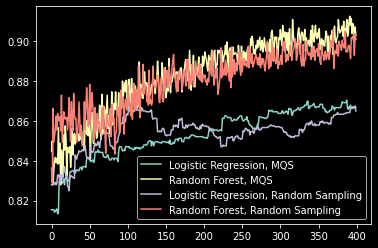

In [36]:

#hide_input

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('dark_background')

pd.DataFrame({
    'Logistic Regression, MQS':history_lr,
    'Random Forest, MQS':history_rf,
    'Logistic Regression, Random Sampling':history_baseline_lr,
    'Random Forest, Random Sampling':history_baseline_rf,
    }).plot()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

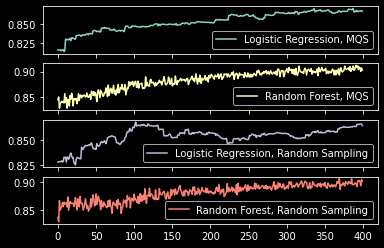

In [35]:
#hide_input
pd.DataFrame({
    'Logistic Regression, MQS':history_lr,
    'Random Forest, MQS':history_rf,
    'Logistic Regression, Random Sampling':history_baseline_lr,
    'Random Forest, Random Sampling':history_baseline_rf,
    }).plot(subplots=True)